# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# addition library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

In order to analyze the problem and solution in next sections, we need to explore the dataset which includes checking the missing value, visualizing the data distribution, etc. 

## Portfolio Dataset

In [2]:
# Check the portfolio
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


- There is no null values here

In [4]:
portfolio.id.nunique()

10

- There are 10 different types of offers disbursed to the customers by starbucks

In [5]:
# Offers of each type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [6]:
## Converting id column to offer_id
portfolio.rename(columns={'id':'offer_id'},inplace=True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


## Profile Dataset

In [7]:
# Check the profile
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

- There are some null value in gender and income, so it will be better to remove the rows where gender or income are null

In [10]:
# Age Column
#profile[profile.age == 118][['gender','age','income']]

profile_nan = profile[profile['gender'].isna() & profile['income'].isna()]
print(profile_nan)

       age  became_member_on gender                                id  income
0      118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783     NaN
2      118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5     NaN
4      118          20170804   None  a03223e636434f42ac4c3df47e8bac43     NaN
6      118          20170925   None  8ec6ce2a7e7949b1bf142def7d0e0586     NaN
7      118          20171002   None  68617ca6246f4fbc85e91a2a49552598     NaN
9      118          20161122   None  8974fc5686fe429db53ddde067b88302     NaN
10     118          20170824   None  c4863c7985cf408faee930f111475da3     NaN
11     118          20150919   None  148adfcaa27d485b82f323aaaad036bd     NaN
17     118          20170801   None  744d603ef08c4f33af5a61c8c7628d1c     NaN
23     118          20170907   None  2b826eba31074a059d63b0ae8f50b7d5     NaN
26     118          20170330   None  65aba5c617294649aeb624da249e1ee5     NaN
36     118          20160707   None  4beeb3ed64dd4898b0edf2f6b67

- All rows that age is 118 has gender and income is null, so we can drop these

In [11]:
def clean_profile(profile):
    '''
    reformat the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile['membersday'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['membersday'] = profile['membersday'].dt.days
    
    
    return profile

In [12]:
# No of unique users
profile.id.nunique()

17000

In [13]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [14]:
# Clean profile dataframe all missing values
profile = clean_profile(profile)

In [15]:
# Check data after cleaned
profile.head()

,age,became_member_on,gender,id,income,membersday
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1961
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2028
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1676
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,1752
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1842


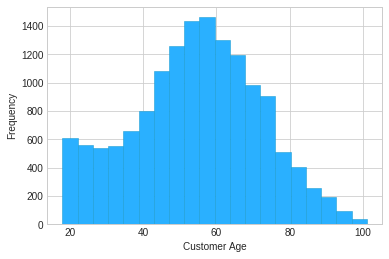

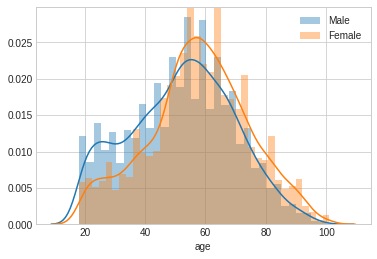

In [16]:
# Display Histogram of Customer Age
plt.style.use('seaborn-whitegrid')
plt.hist(profile['age'], bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel("Customer Age")
plt.ylabel('Frequency')
plt.show()

## Gender-wise age distribution
sns.distplot(profile[profile.gender=='M'].age,label='Male')
sns.distplot(profile[profile.gender=='F'].age,label='Female')
stat="density"
plt.legend()
plt.show()

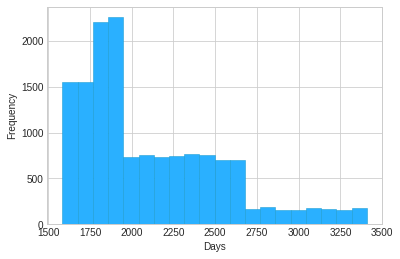

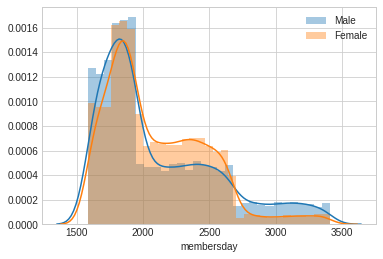

In [17]:
# Display Histogram of the days being member
plt.style.use('seaborn-whitegrid')
plt.hist(profile['membersday'], bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel("Days")
plt.ylabel('Frequency')
plt.show()

## Gender-wise membersday distribution
sns.distplot(profile[profile.gender=='M'].membersday,label='Male')
sns.distplot(profile[profile.gender=='F'].membersday,label='Female')
plt.legend()
plt.show()

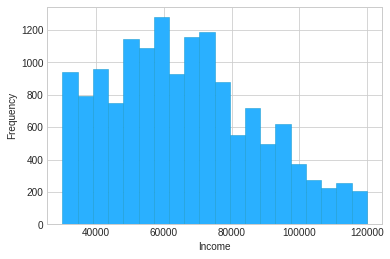

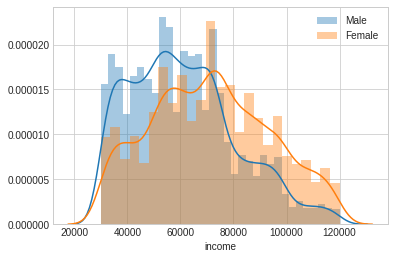

In [18]:
# Display Histogram of User Income
plt.style.use('seaborn-whitegrid')
plt.hist(profile['income'], bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel("Income")
plt.ylabel('Frequency')
plt.show()

## Gender-wise membersday distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

## Transcript dataset

In [19]:
# Check the transcript
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


- Value column may have to be preprocessed depending on the event.

In [20]:
# Check it has any missing value
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [21]:
# Event distribution
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [22]:
# Extract the different values in value column out
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [23]:
# clean up the duplicates in offer id and offer_id and meger into one column
transcript['cleaned_offer_id_temp'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])

# Drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# Rename the offer_id column
transcript.rename(columns={'cleaned_offer_id_temp': 'offer_id'}, inplace=True)

In [24]:
# Quick check on cleaned dataframe
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [25]:
transcript.offer_id.nunique()

10

In [26]:
transcript.person.nunique()

17000

In [27]:
offer_temp = pd.merge(transcript,portfolio,how='left',on='offer_id')
offer_temp.head()

,event,person,time,value,amount,reward_x,offer_id,channels,difficulty,duration,offer_type,reward_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo,10.0


In [28]:
offer_temp.groupby(['offer_type','event']).person.count()

offer_type     event          
bogo           offer completed    15669
               offer received     30499
               offer viewed       25449
discount       offer completed    17910
               offer received     30543
               offer viewed       21445
informational  offer received     15235
               offer viewed       10831
Name: person, dtype: int64

In [29]:
# quick view on event distribution by offer_type by combining two dataset (portfolio, transcript)
transcript=transcript.merge(portfolio,how='left',on='offer_id')
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

In [30]:
# drop the useless columns
processed_transcript = pd.DataFrame(transcript)

processed_transcript = processed_transcript.drop(columns=['reward_x','reward_y'], axis=1,inplace=False)
processed_transcript.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo


In [31]:
# sort the events by person and time
processed_transcript = processed_transcript.sort_values(['person','time'])
processed_transcript.head(5)

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational


In [32]:
# Filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offer_completed = processed_transcript[['time','offer_id','person','event']][(processed_transcript['event']\
    =='transaction') | (processed_transcript['event']=='offer viewed')]
offer_completed.update(offer_completed.groupby(['person']).ffill())
offer_completed['offer_id'] = offer_completed['offer_id'].ffill()

In [33]:
# Since the above temporary dataset is just a subset of the transcript dataset, I can create a new dataset with the filled in offer ids for transactions.
processed_transcript = processed_transcript.merge(offer_completed, how='left', on=['person','time','event'])
processed_transcript.head()

,event,person,time,value,amount,offer_id_x,channels,difficulty,duration,offer_type,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


In [34]:
# Clean up the dataframe (removing the dummy columns)
processed_transcript['offer_id'] = np.where(processed_transcript['offer_id_x'].isnull(),\
                                            processed_transcript['offer_id_y'], processed_transcript['offer_id_x'])
processed_transcript.drop(columns=['offer_id_x','offer_id_y'], axis=1, inplace=True)

In [35]:
# Merge portfolio dataset to get offer data
processed_transcript = processed_transcript.merge(portfolio, how = 'left',on='offer_id')
processed_transcript['duration'] = np.where(processed_transcript['duration_x'].isnull(), \
                                            processed_transcript['duration_y'], processed_transcript['duration_x'])
processed_transcript.drop(columns=['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],\
                         axis=1, inplace=True)
processed_transcript.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [36]:
# Check on processed dataset
processed_transcript.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


In [37]:
# subset the dataset with only offer viewed, transaction, and offer completed events
transactions_after_viewed = processed_transcript[(processed_transcript['event']=='offer viewed')|\
                                                 (processed_transcript['event']=='transaction')|\
                                                 (processed_transcript['event']=='offer completed')].copy()

# generate the previous offer id
transactions_after_viewed['pre_offer_id'] = transactions_after_viewed.groupby(['person', 'offer_id'])['offer_id'].shift()

# create flag for responsed offer which competed after customer viewing the offer
transactions_after_viewed['completed_offer'] = np.where(transactions_after_viewed['pre_offer_id']==\
                                                       transactions_after_viewed['offer_id'],1,0)

In [38]:
transactions_after_viewed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,3f207df678b143eea3cee63160fa8bed,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0


In [39]:
offer_received = pd.DataFrame(processed_transcript)
# join back the 'offer received' events which was filtered out in the previous step
offer_received = offer_received[offer_received['event']=='offer received']

offer_received['pre_offer_id']=np.nan
offer_received['completed_offer']=np.nan

processed_transcript = offer_received.append(transactions_after_viewed).sort_values(['person','time'])
processed_transcript.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0


In [40]:
#split transcript into 3 different offer types
bogo = processed_transcript[processed_transcript['offer_type']=='bogo'].copy()
discount = processed_transcript[processed_transcript['offer_type']=='discount'].copy()
informational = processed_transcript[processed_transcript['offer_type']=='informational'].copy()

In [41]:
# quick view on seperated data
bogo.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
5,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,NaN
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0.0
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
10,transaction,0009655768c64bdeb2e877511632db8f,528,{'amount': 14.11},14.11,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
20,offer received,00116118485d4dfda04fdbaba9a87b5c,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,NaN


In [42]:
discount.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
9,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,NaN,NaN
11,offer completed,0009655768c64bdeb2e877511632db8f,528,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,NaN,0.0
12,offer viewed,0009655768c64bdeb2e877511632db8f,540,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
13,transaction,0009655768c64bdeb2e877511632db8f,552,{'amount': 13.56},13.56,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
14,offer received,0009655768c64bdeb2e877511632db8f,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,discount,2,7.0,NaN,NaN


In [43]:
informational.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0


In [44]:
# Defining Group1 peoples
bogo_completed = bogo[['person','offer_id']][(bogo['completed_offer']==1) & (bogo['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
discount_completed = discount[['person','offer_id']][(discount['completed_offer']==1) & (discount['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()

In [45]:
# Again, we define a function as we will repeat this for 2 datasets - BOGO & discount
def not_converted(df):
    
    '''
    Takes in transcript dataframe of single offer type to check for people of group2 and group4.
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unique person-offer_id pairs with conversion events and offers received events, with indicator of each.
    
    Note: left_only indicator is just the offers received events, right_only is just conversion events (transaction and offer_completed)
       
    '''
    
    #subset offer ids that have transactions or conversions by person and offer_id
    conversion_ids=df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()

    #check for unique person-offer_id pairs that consist of offers received 
    offers_received_only=df[['person','offer_id']][df['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

    #create merged dataset to diffrentiate groups
    check_merge=conversion_ids.merge(offers_received_only,how='right',on=['person','offer_id'],indicator=True)
    return check_merge

#check how many are in either group
check_merge_bogo=not_converted(bogo)
print('For BOGO offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount=not_converted(discount)
print('For Discount offers:')
print(check_merge_discount.groupby(['_merge']).count())

For BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
For Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


In [46]:
grp_2_4_bogo = check_merge_bogo[check_merge_bogo['_merge'] == 'right_only']
grp_2_4_bogo  = grp_2_4_bogo.merge(processed_transcript,how='left',on=['person','offer_id'])
grp_2_bogo = grp_2_4_bogo[['person','offer_id']][grp_2_4_bogo['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4_bogo.drop(['_merge'], axis=1, inplace=True)
grp_4_bogo=grp_2_4_bogo.merge(grp_2_bogo[['person','offer_id']],how='left',indicator=True)
grp_4_bogo=grp_4_bogo[grp_4_bogo['_merge']=='left_only'].copy()

In [47]:
# do the same action on discount offer

# subtract the customers who received the offer without finishing the transaction
grp_2_4_discount = check_merge_discount[check_merge_discount['_merge']=='right_only']
grp_2_4_discount = grp_2_4_discount.merge(processed_transcript, how='left',on=['person','offer_id'])

# subset users who only viewed the offer and people who viewed the offer but didn't make transaction
grp_2_discount = grp_2_4_discount[['person','offer_id']][grp_2_4_discount['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
grp_2_4_discount.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the discount offer 
grp_4_discount = grp_2_4_discount.merge(grp_2_discount[['person','offer_id']], how='left', indicator=True)
grp_4_discount = grp_4_discount[grp_4_discount['_merge']=='left_only'].copy()

In [48]:
# subset the offer which has no correction with offer
grp3_bogo = bogo[['person','offer_id']][(bogo['event']=='offer completed') & (bogo['completed_offer']!=1)]\
                    .groupby(['person','offer_id']).count().reset_index()
grp3_discount = discount[['person','offer_id']][(discount['event']=='offer completed')\
                    & (discount['completed_offer']!=1)].groupby(['person','offer_id']).count().reset_index()

In [49]:
def final_offers_dataset(grp1,grp2):
    '''
    inputs:
    - grp1: dataframe containing group1 customer data 
    - grp2: dataframe containing group2 customer data
    
    outputs:
    - Returns dataframe with labeled effective offer column
    '''
    #assign effective offer flag column
    grp1['effective_offer']=1
    grp2['effective_offer']=0

    #append datasets together
    offers=grp1.append(grp2,sort=False)
    return offers

offers_bogo=final_offers_dataset(bogo_completed,grp_2_bogo)
offers_discount=final_offers_dataset(discount_completed,grp_2_discount)

In [50]:
#convert time into days
informational['day_offer']=informational['time']/24
#drop unnecessary columns
informational.drop(['time','value','pre_offer_id'], axis=1, inplace=True)

In [51]:
#sort transactions to ensure all events occurring by person and offer
informational=informational.sort_values(['person','day_offer','event','offer_id'])

In [52]:
#get difference in time for informational offers
informational['diff']=informational[(informational['offer_type']=='informational') & ((informational['event']=='offer received') | (informational['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()


In [53]:
#create column for flagging valid events
informational['valid_completed_duration']=np.nan
#flag valid events if within duration
informational.loc[informational['diff']<=informational['duration'],'valid_completed_duration']=1
#fill any missing values with 0 flag
informational['valid_completed_duration']=informational['valid_completed_duration'].fillna(value=0)

In [54]:
informational.head(1)

,event,person,amount,offer_id,channels,difficulty,offer_type,reward,duration,completed_offer,day_offer,diff,valid_completed_duration
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,7.0,NaN,0.0


In [55]:
#flag effective_offers where completed_offer = 1 and valid_completed_duration = 1
informational['offer_responded']=np.where(((informational['completed_offer']==1)\
                                           & (informational['valid_completed_duration']==1)),1,0)

In [56]:
#separate group 1 in transcript_into
info_completed = informational[['person','offer_id']][informational['offer_responded']==1]\
                        .groupby(['person','offer_id']).sum().reset_index()

In [57]:
#separate out group 2 of customers
check_merge_info=not_converted(informational)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [58]:
grp_2_4_info = check_merge_info[check_merge_info['_merge'] == 'right_only']
grp_2_4_info  = grp_2_4_info.merge(processed_transcript,how='left',on=['person','offer_id'])
grp_2_info = grp_2_4_info[['person','offer_id']][grp_2_4_info['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4_info.drop(['_merge'], axis=1, inplace=True)
grp_4_info=grp_2_4_info.merge(grp_2_info[['person','offer_id']],how='left',indicator=True)
grp_4_info=grp_4_info[grp_4_info['_merge']=='left_only'].copy()

In [59]:
#scenario 1
grp3_1=informational[['person','offer_id']][(informational['event']=='transaction')&(informational['completed_offer']!=1) & (informational['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()
#scenario 2
grp3_2=informational[['person','offer_id']][(informational['event']=='transaction')&(informational['completed_offer']==1) & (informational['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
grp_3_info=grp3_1.append(grp3_2,sort=False)
del grp3_1
del grp3_2

In [60]:
offers_info=final_offers_dataset(info_completed,grp_2_info)

In [61]:
offers_bogo

,person,offer_id,effective_offer
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1
5,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,1
6,0056df74b63b4298809f0b375a304cf4,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
7,0082fd87c18f45f2be70dbcbb0fb8aad,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
8,0091d2b6a5ea4defaa8393e4e816db60,4d5c57ea9a6940dd891ad53e9dbe8da0,1
9,0091d2b6a5ea4defaa8393e4e816db60,f19421c1d4aa40978ebb69ca19b0e20d,1


In [62]:
profile.rename(columns={'id':'person'},inplace=True)

#create function to generate the length of time since the user become the member
def member_since(df):
    '''
    inputs:
    - df: dataframe to generate the length of time since the user become the member
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    # drop all missing values
    df = df.dropna(subset=['became_member_on'])
    
    df['became_member_on'] = df['became_member_on'].astype(int)
    df['became_member_on'] = df['became_member_on'].apply(str)
    
    #convert became_member_on into member tenure
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-4:-2]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df = df.drop('became_member_on', axis=1, inplace=False)
    df.loc[df['year'] == 2018, 'membership_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df = df.drop(['year','month','day'], axis=1, inplace=False)
    
    return df

offers_bogo=member_since(offers_bogo)
offers_discount=member_since(offers_discount)
offers_info=member_since(offers_info)

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


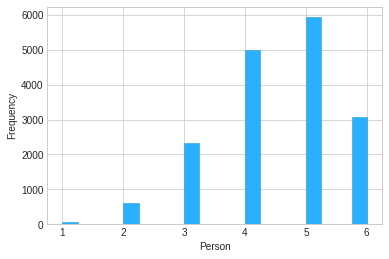

In [63]:
#group event=offer received per person in transactional records
print(processed_transcript[processed_transcript['event']=='offer received'].groupby('person')['event'].count().head())

# Display Histogram of offers received per person
plt.style.use('seaborn-whitegrid')
plt.hist(processed_transcript[processed_transcript['event']=='offer received'].groupby('person')['event'].count(), bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel("Person")
plt.ylabel('Frequency')
plt.show()


In [64]:
#get count of offers received per person, put into separate dataset
df_offer_received_cnt=processed_transcript[processed_transcript['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()

#rename columns
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

#drop unnecessary columns
df_offer_received_cnt.drop(['time'], axis=1, inplace=True)

#ensure only unique person-offer_id pairs
df_offer_received_cnt=df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()

In [65]:
#filter dataset by invalid transactions
# subtract the transactions which's not related to the offer
transactions_not_related=processed_transcript[(processed_transcript['event']=='transaction') & (processed_transcript['completed_offer']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
transactions_not_related.rename(columns={'amount':'amount_invalid'},inplace=True)

In [66]:
# merge to get offers received count and invalid amount transacted 
offers_bogo=offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
offers_bogo=offers_bogo.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

In [67]:
#check % of missing values in dataset
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending=False).head()

amount_invalid        96.150403
membership_days        5.876129
offer_received_cnt     0.000000
membersday             0.000000
income                 0.000000
dtype: float64

In [68]:
# fill missing values for amount_invalid with 0
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)
offers_bogo.dropna(inplace=True)

In [69]:
#foresee need to reuse dummy variable encoding function
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=df.drop(columns=col,axis=1,inplace=False)
    return df

In [70]:
offers_bogo

,person,offer_id,effective_offer,age,gender,income,membersday,membership_days,offer_received_cnt,amount_invalid
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40.0,O,57000.0,1783.0,39.0,1,0.0
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59.0,F,90000.0,2459.0,824.0,1,0.0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24.0,F,60000.0,2207.0,1071.0,1,0.0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24.0,F,60000.0,2207.0,1071.0,1,0.0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55.0,F,74000.0,1664.0,158.0,1,0.0
5,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,1,54.0,M,99000.0,2432.0,851.0,2,0.0
6,0056df74b63b4298809f0b375a304cf4,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,54.0,M,91000.0,2289.0,991.0,1,0.0
7,0082fd87c18f45f2be70dbcbb0fb8aad,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,28.0,F,68000.0,1906.0,643.0,2,0.0
8,0091d2b6a5ea4defaa8393e4e816db60,4d5c57ea9a6940dd891ad53e9dbe8da0,1,62.0,F,81000.0,2354.0,927.0,2,0.0
9,0091d2b6a5ea4defaa8393e4e816db60,f19421c1d4aa40978ebb69ca19b0e20d,1,62.0,F,81000.0,2354.0,927.0,2,0.0


In [71]:
#merge with portfolio to get offer details
offers_bogo=offers_bogo.merge(portfolio,how='left',on='offer_id')

# apply one hot encoding to channels column
offers_bogo['web'] = offers_bogo['channels'].apply(lambda x: 1 if 'web' in x else 0)
offers_bogo['email'] = offers_bogo['channels'].apply(lambda x: 1 if 'email' in x else 0)
offers_bogo['mobile'] = offers_bogo['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
offers_bogo['social'] = offers_bogo['channels'].apply(lambda x: 1 if 'social' in x else 0)

##convert channels into categorical variables
#for index, row in offers_bogo.iterrows():
#    for channel in ['web', 'email', 'social', 'mobile']:
#        if channel in offers_bogo.loc[index, 'channels']:
#            offers_bogo.loc[index, channel] = 1
#        else:
#            offers_bogo.loc[index, channel] = 0

In [72]:
offers_bogo = offers_bogo.drop(['channels'], axis=1, inplace=False)

#convert gender into categorical variables
offers_bogo=dummy(offers_bogo,'gender')

In [73]:
offers_bogo.head()

,person,offer_id,effective_offer,age,income,membersday,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,mobile,social,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40.0,57000.0,1783.0,39.0,1,0.0,5,7,bogo,5,1,1,1,0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59.0,90000.0,2459.0,824.0,1,0.0,10,5,bogo,10,1,1,1,1,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24.0,60000.0,2207.0,1071.0,1,0.0,5,7,bogo,5,1,1,1,0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24.0,60000.0,2207.0,1071.0,1,0.0,5,5,bogo,5,1,1,1,1,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55.0,74000.0,1664.0,158.0,1,0.0,5,5,bogo,5,1,1,1,1,1,0,0


In [74]:
def prep_offers_df(df):
    
    '''
    inputs:
    - df: original dataframe for modeling 
    
    outputs:
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
    
    #fill missing values for amount_invalid with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    
    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #merge with portfolio to get offer details
    df=df.merge(portfolio,how='left',on='offer_id')

    #convert channels into categorical variables
    for index, row in df.iterrows():
        for channel in ['web', 'email', 'social', 'mobile']:
            if channel in df.loc[index, 'channels']:
                df.loc[index, channel] = 1
            else:
                df.loc[index, channel] = 0
    df = df.drop(['channels'], axis=1, inplace=False)
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')

    return df

In [75]:
#prepare data for offer_discounts
offers_discount=prep_offers_df(offers_discount)

In [76]:
offers_discount.head()

,person,offer_id,effective_offer,age,income,membersday,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40.0,57000.0,1783.0,39.0,1,0.0,20,10,discount,5,1.0,1.0,0.0,0.0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40.0,57000.0,1783.0,39.0,1,0.0,7,7,discount,3,1.0,1.0,1.0,1.0,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59.0,90000.0,2459.0,824.0,2,0.0,10,10,discount,2,1.0,1.0,1.0,1.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24.0,60000.0,2207.0,1071.0,1,0.0,7,7,discount,3,1.0,1.0,1.0,1.0,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26.0,73000.0,1985.0,566.0,2,0.0,10,10,discount,2,1.0,1.0,1.0,1.0,1,0,0


In [77]:
#merge with portfolio to get offer details
offers_info=offers_info.merge(portfolio,how='left',on='offer_id')

#reset index for offers_info
offers_info = offers_info.reset_index().drop(['index'],axis=1,inplace=False)


#convert channels into categorical variables
for index, row in offers_info.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in offers_info.loc[index, 'channels']:
            offers_info.loc[index, channel] = 1
        else:
            offers_info.loc[index, channel] = 0
offers_info = offers_info.drop(['channels'], axis=1, inplace=False)

In [78]:
#repurpose function for offers_info
def prep_offers_df(df):
    '''
    inputs:
    - df: dataframe to be transformed 
    
    outputs:
    - Returns dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    #fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)

    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')
    return df

In [79]:
offers_info=prep_offers_df(offers_info)
offers_info.head()

,person,offer_id,effective_offer,age,income,membersday,membership_days,difficulty,duration,offer_type,reward,web,email,social,mobile,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33.0,72000.0,2046.0,506.0,0,4,informational,0,1.0,1.0,0.0,1.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33.0,72000.0,2046.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59.0,90000.0,2459.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24.0,60000.0,2207.0,1071.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26.0,73000.0,1985.0,566.0,0,4,informational,0,1.0,1.0,0.0,1.0,1.0,0.00,1,0,0


In [80]:
#check for class balance in datasets
print(offers_bogo[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo))
print(offers_discount[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount))
print((offers_info[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info)))

                   person
effective_offer          
0                0.126502
1                0.873498
                   person
effective_offer          
0                0.070614
1                0.929386
                   person
effective_offer          
0                0.149382
1                0.850618


In [81]:
def data_prep(df,col_drop):
    '''
    inputs:
    - df: prepared dataframe for modeling and columns to be dropped
    
    outputs:
    - Returns 2 dataframes - features and target dataframes
    '''
    # Split the data into features and target label
    target = df['effective_offer']
    features = df.drop(columns = col_drop,inplace=False,axis=1)
    return features,target

In [82]:
def model_pipeline(features,target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [83]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test)
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [84]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

In [85]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9252 samples.
MSE_train: 0.1175
MSE_test: 0.1141
Training accuracy:0.8825
Test accuracy:0.8859
             precision    recall  f1-score   support

          0     0.6211    0.2056    0.3089       287
          1     0.8972    0.9822    0.9378      2026

avg / total     0.8629    0.8859    0.8598      2313

RandomForestClassifier trained on 9252 samples.
MSE_train: 0.1087
MSE_test: 0.1154
Training accuracy:0.8913
Test accuracy:0.8846
             precision    recall  f1-score   support

          0     0.6515    0.1498    0.2436       287
          1     0.8914    0.9886    0.9375      2026

avg / total     0.8616    0.8846    0.8514      2313



In [86]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 9471 samples.
MSE_train: 0.0731
MSE_test: 0.0608
Training accuracy:0.9269
Test accuracy:0.9392
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       144
          1     0.9392    1.0000    0.9686      2224

avg / total     0.8821    0.9392    0.9097      2368



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9471 samples.
MSE_train: 0.0677
MSE_test: 0.0579
Training accuracy:0.9323
Test accuracy:0.9421
             precision    recall  f1-score   support

          0     0.8889    0.0556    0.1046       144
          1     0.9423    0.9996    0.9701      2224

avg / total     0.9391    0.9421    0.9175      2368



In [87]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 4852 samples.
MSE_train: 0.1496
MSE_test: 0.1401
Training accuracy:0.8504
Test accuracy:0.8599
             precision    recall  f1-score   support

          0     0.5556    0.0581    0.1053       172
          1     0.8644    0.9923    0.9240      1041

avg / total     0.8206    0.8599    0.8079      1213

RandomForestClassifier trained on 4852 samples.
MSE_train: 0.1461
MSE_test: 0.1401
Training accuracy:0.8539
Test accuracy:0.8599
             precision    recall  f1-score   support

          0     0.7500    0.0174    0.0341       172
          1     0.8602    0.9990    0.9244      1041

avg / total     0.8446    0.8599    0.7982      1213



In [88]:
#define function to find best model results for each offer type
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print('For ' + offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]


In [89]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [25,30,40,50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [90]:
#define BOGO dataset
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 40}

In [91]:
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=25,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9252 samples.
MSE_train: 0.1175
MSE_test: 0.1141
Training accuracy:0.8825
Test accuracy:0.8859
             precision    recall  f1-score   support

          0     0.6211    0.2056    0.3089       287
          1     0.8972    0.9822    0.9378      2026

avg / total     0.8629    0.8859    0.8598      2313

RandomForestClassifier trained on 9252 samples.
MSE_train: 0.1025
MSE_test: 0.1128
Training accuracy:0.8975
Test accuracy:0.8872
             precision    recall  f1-score   support

          0     0.6477    0.1986    0.3040       287
          1     0.8966    0.9847    0.9386      2026

avg / total     0.8657    0.8872    0.8599      2313



In [92]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.029542,0.036717
testing_score,0.884565,0.887160
train_time,0.175386,0.229964
training_score,0.891267,0.897536


In [93]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.036717,0.88716,0.229964,0.897536


In [94]:
#define discount dataset
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 40}

In [95]:

X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 9471 samples.
MSE_train: 0.0731
MSE_test: 0.0608
Training accuracy:0.9269
Test accuracy:0.9392
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       144
          1     0.9392    1.0000    0.9686      2224

avg / total     0.8821    0.9392    0.9097      2368



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9471 samples.
MSE_train: 0.0646
MSE_test: 0.0608
Training accuracy:0.9354
Test accuracy:0.9392
             precision    recall  f1-score   support

          0     0.5000    0.0486    0.0886       144
          1     0.9418    0.9969    0.9685      2224

avg / total     0.9149    0.9392    0.9150      2368



In [96]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.034306,0.044541
testing_score,0.942145,0.939189
train_time,0.179650,0.272290
training_score,0.932320,0.935382


In [97]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_1,0.034306,0.942145,0.17965,0.93232


In [98]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 30}

In [99]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_2 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=25,min_samples_leaf=20)

results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 4852 samples.
MSE_train: 0.1496
MSE_test: 0.1401
Training accuracy:0.8504
Test accuracy:0.8599
             precision    recall  f1-score   support

          0     0.5556    0.0581    0.1053       172
          1     0.8644    0.9923    0.9240      1041

avg / total     0.8206    0.8599    0.8079      1213

RandomForestClassifier trained on 4852 samples.
MSE_train: 0.1507
MSE_test: 0.1418
Training accuracy:0.8493
Test accuracy:0.8582
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       172
          1     0.8582    1.0000    0.9237      1041

avg / total     0.7365    0.8582    0.7927      1213



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [100]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.017940,0.018940
testing_score,0.859852,0.858203
train_time,0.103214,0.122546
training_score,0.853875,0.849340


In [101]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
DecisionTreeClassifier_info_1,0.000750,0.859852,0.013196,0.850371
RandomForestClassifier_info_1,0.017940,0.859852,0.103214,0.853875
DecisionTreeClassifier_info_2,0.000759,0.859852,0.013492,0.850371


In [102]:
#add amount_invalid variable to drop_cols_prep list
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']

#train BOGO model
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=25,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_3,'bogo_3')],axis=1)

DecisionTreeClassifier trained on 9252 samples.
MSE_train: 0.1175
MSE_test: 0.1141
Training accuracy:0.8825
Test accuracy:0.8859
             precision    recall  f1-score   support

          0     0.6211    0.2056    0.3089       287
          1     0.8972    0.9822    0.9378      2026

avg / total     0.8629    0.8859    0.8598      2313

RandomForestClassifier trained on 9252 samples.
MSE_train: 0.0991
MSE_test: 0.1133
Training accuracy:0.9009
Test accuracy:0.8867
             precision    recall  f1-score   support

          0     0.6623    0.1777    0.2802       287
          1     0.8945    0.9872    0.9385      2026

avg / total     0.8657    0.8867    0.8568      2313



In [103]:
results[['RandomForestClassifier_bogo_2','RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
pred_time,0.036717,0.038052
testing_score,0.887160,0.886727
train_time,0.229964,0.194013
training_score,0.897536,0.900886


In [104]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.036717,0.88716,0.229964,0.897536


In [105]:
#train discount model
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_3,'discount_3')],axis=1)

DecisionTreeClassifier trained on 9471 samples.
MSE_train: 0.0731
MSE_test: 0.0608
Training accuracy:0.9269
Test accuracy:0.9392
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       144
          1     0.9392    1.0000    0.9686      2224

avg / total     0.8821    0.9392    0.9097      2368



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9471 samples.
MSE_train: 0.0643
MSE_test: 0.0583
Training accuracy:0.9357
Test accuracy:0.9417
             precision    recall  f1-score   support

          0     0.7500    0.0625    0.1154       144
          1     0.9427    0.9987    0.9699      2224

avg / total     0.9310    0.9417    0.9179      2368



In [106]:
results[['RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
pred_time,0.044541,0.044997
testing_score,0.939189,0.941723
train_time,0.272290,0.254377
training_score,0.935382,0.935698


In [107]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_1,0.034306,0.942145,0.17965,0.93232


In [108]:
#train info model
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_3 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=25,min_samples_leaf=20)

results=pd.concat([results[:],run_model(baseline,info_3,'info_3')],axis=1)

DecisionTreeClassifier trained on 4852 samples.
MSE_train: 0.1496
MSE_test: 0.1401
Training accuracy:0.8504
Test accuracy:0.8599
             precision    recall  f1-score   support

          0     0.5556    0.0581    0.1053       172
          1     0.8644    0.9923    0.9240      1041

avg / total     0.8206    0.8599    0.8079      1213

RandomForestClassifier trained on 4852 samples.
MSE_train: 0.1509
MSE_test: 0.1418
Training accuracy:0.8491
Test accuracy:0.8582
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       172
          1     0.8582    1.0000    0.9237      1041

avg / total     0.7365    0.8582    0.7927      1213



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [109]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
pred_time,0.018940,0.022197
testing_score,0.858203,0.858203
train_time,0.122546,0.107201
training_score,0.849340,0.849134


In [110]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
DecisionTreeClassifier_info_1,0.000750,0.859852,0.013196,0.850371
RandomForestClassifier_info_1,0.017940,0.859852,0.103214,0.853875
DecisionTreeClassifier_info_2,0.000759,0.859852,0.013492,0.850371
DecisionTreeClassifier_info_3,0.000674,0.859852,0.013398,0.850371


In [111]:
#get best model sumary for bogo,discount and info offers
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_2,RandomForestClassifier_discount_1,DecisionTreeClassifier_info_1,RandomForestClassifier_info_1,DecisionTreeClassifier_info_2,DecisionTreeClassifier_info_3
pred_time,0.036717,0.034306,0.000750,0.017940,0.000759,0.000674
testing_score,0.887160,0.942145,0.859852,0.859852,0.859852,0.859852
train_time,0.229964,0.179650,0.013196,0.103214,0.013492,0.013398
training_score,0.897536,0.932320,0.850371,0.853875,0.850371,0.850371


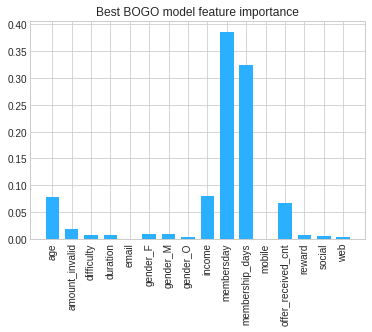

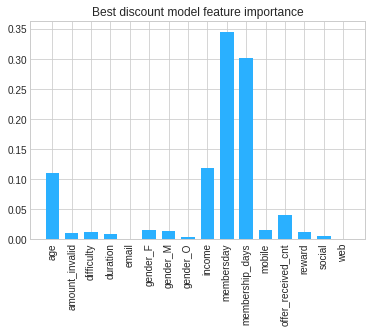

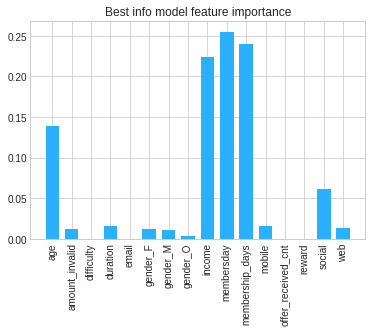

In [112]:
#show feature importance
#BOGO 3 model
#prepare data same as BOGO 3 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)

plt.style.use('seaborn-whitegrid')
plt.bar(features.columns, bogo_2.feature_importances_, color ='#2ab0ff', width = 0.7)
plt.xticks(rotation='vertical')
plt.title('Best BOGO model feature importance')
plt.show()

#discount 3 model
plt.style.use('seaborn-whitegrid')
plt.bar(features.columns, discount_2.feature_importances_, color ='#2ab0ff', width = 0.7)
plt.xticks(rotation='vertical')
plt.title('Best discount model feature importance')
plt.show()

#info_2 model
#prepare data similar to info_2 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)

plt.bar(features.columns, info_2.feature_importances_, color ='#2ab0ff', width = 0.7)
plt.xticks(rotation='vertical')
plt.title('Best info model feature importance')
plt.show()

In [113]:
results

,DecisionTreeClassifier_bogo_1,RandomForestClassifier_bogo_1,DecisionTreeClassifier_discount_1,RandomForestClassifier_discount_1,DecisionTreeClassifier_info_1,RandomForestClassifier_info_1,DecisionTreeClassifier_bogo_2,RandomForestClassifier_bogo_2,DecisionTreeClassifier_discount_2,RandomForestClassifier_discount_2,DecisionTreeClassifier_info_2,RandomForestClassifier_info_2,DecisionTreeClassifier_bogo_3,RandomForestClassifier_bogo_3,DecisionTreeClassifier_discount_3,RandomForestClassifier_discount_3,DecisionTreeClassifier_info_3,RandomForestClassifier_info_3
pred_time,0.001252,0.029542,0.001425,0.034306,0.000750,0.017940,0.001197,0.036717,0.001269,0.044541,0.000759,0.018940,0.001166,0.038052,0.001221,0.044997,0.000674,0.022197
testing_score,0.885863,0.884565,0.939189,0.942145,0.859852,0.859852,0.885863,0.887160,0.939189,0.939189,0.859852,0.858203,0.885863,0.886727,0.939189,0.941723,0.859852,0.858203
train_time,0.024896,0.175386,0.024665,0.179650,0.013196,0.103214,0.024508,0.229964,0.025230,0.272290,0.013492,0.122546,0.024576,0.194013,0.024754,0.254377,0.013398,0.107201
training_score,0.882512,0.891267,0.926935,0.932320,0.850371,0.853875,0.882512,0.897536,0.926935,0.935382,0.850371,0.849340,0.882512,0.900886,0.926935,0.935698,0.850371,0.849134
